# <h1 align="center">**Project 2 - Image Processing** </h1>

<h3 align="center"> Đặng Ngọc Tiến - 20127641</h3>

##### **Import Library**

In [230]:
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

##### **1. Adjust Brightness**

In [231]:
def adjust_brightness(img, brightness):
    return np.uint8(np.clip(img + np.array([brightness], dtype=np.int16), 0, 255))

##### **2. Adjust contrast**

In [232]:
def adjust_contrast(img, contrast):
    contrast = np.clip(float(contrast), -255, 255)
    factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
    return np.uint8(np.clip(factor * (img.astype(float) - 128) + 128, 0, 255))

##### **3. Flip the image (Vertical / Horizontal)**

In [233]:
def flip(img, direction):
    if direction == 'vertical':
        return np.flipud(img)
    elif direction == 'horizontal':
        return np.fliplr(img)

##### **4. Convert RGB image to grayscale image**

In [234]:
def to_grayscale(img):
    weight = np.array([0.3, 0.59, 0.11])
    return np.uint8(np.dot(img[..., :3], weight))

##### **5. Blend 2 images of the same size**

In [235]:
def blend(img_1, img_2, alpha):
    return np.uint8(alpha * img_1.astype(float) + (1 - alpha) * img_2.astype(float))

##### **6. Blur the image**

##### - Gausian function

In [236]:
def dnorm(x, sigma):
    return np.array(1 / (np.sqrt(2 * np.pi) * sigma) * (np.exp(-np.power(x / sigma, 2) / 2)))

In [237]:
def Gaussian_kernel(kernel_size, sigma):
    kernel_1d = np.linspace(-(kernel_size // 2), kernel_size // 2, num=kernel_size)
    kernel_1d = dnorm(kernel_1d, sigma)
    kernel_2d = np.outer(kernel_1d.T, kernel_1d.T)
    kernel_2d *= 1.0 / np.sum(kernel_2d)
    return kernel_2d 

##### - Convolution function

In [238]:
def convolve_layer(layer, kernel):
    view = kernel.shape + tuple(np.subtract(layer.shape, kernel.shape) + 1)
    submatrices = np.lib.stride_tricks.as_strided(layer, shape = view, strides = layer.strides * 2)
    return np.einsum('ij,ijkl->kl', kernel, submatrices)

In [239]:
def convolution(img, kernel):
    return np.dstack((convolve_layer(img[:,:,0], kernel), convolve_layer(img[:,:,1], kernel), convolve_layer(img[:,:,2], kernel)))

##### - Gaussian blur function

In [240]:
def Gaussian_blur(img, kernel_size):
    kernel = Gaussian_kernel(kernel_size, sigma=(kernel_size-1)/6)
    return np.uint8(convolution(img, kernel))

#### **Test case and export photos**

In [241]:
def test_brightness(image, name_img):
    brightness = input("Enter brightness [-255:255]: ")
    result = adjust_brightness(image, brightness)
    plt.imshow(result)
    output_file = name_img.split('.')[0] + '_' + str(brightness) + '_brightness' + '.png'
    Image.fromarray(result).save(output_file)

In [242]:
def test_contrast(image, name_img):
    contrast = input("Enter contrast [-255:255]: ")
    result = adjust_contrast(image, contrast)
    plt.imshow(result)
    output_file = name_img.split('.')[0] + '_' + str(contrast) + '_contrast' + '.png'
    Image.fromarray(result).save(output_file)

In [243]:
def test_flip(image, name_img):
    print("""
    1. Vertical
    2. Horizontal
    """)
    direction = input("Enter direction: ")
    if direction == '1':
        direction = 'vertical'
    elif direction == '2':
        direction = 'horizontal'
    result = flip(image, direction)
    plt.imshow(result)

    output_file = name_img.split('.')[0] + '_flip_' + direction + '.png'
    Image.fromarray(result).save(output_file)


In [244]:
def test_grayscale(image, name_img):
    result = to_grayscale(image)
    plt.imshow(result, cmap='gray')

    output_file = name_img.split('.')[0] + '_grayscale' + '.png'
    Image.fromarray(result).save(output_file, cmap='gray')

In [245]:
def test_blend():
    print("Enter image1 name: ")
    name_img1 = input()
    image1 = Image.open(name_img1)
    image1 = np.array(image1)
    print("Enter image2 name: ")
    name_img2 = input()
    image2 = Image.open(name_img2)
    image2 = np.array(image2)
    
    image_1 = to_grayscale(image1)
    image_2 = to_grayscale(image2)

    alpha = 0.5
    result = blend(image_1, image_2, alpha)
    plt.imshow(result, cmap='gray')

    output_file = name_img1.split('.')[0] + '_' + name_img2.split('.')[0] + '_blend' + '.png'
    Image.fromarray(result).save(output_file, cmap='gray')

In [246]:
def test_blur(image, name_img):
    kernel_size = int(input("Enter kernel size: "))
    result = Gaussian_blur(image, kernel_size)
    plt.imshow(result)
 
    output_file = name_img.split('.')[0] + '_blur_' + str(kernel_size) + '.png'
    Image.fromarray(result).save(output_file)

### **Advanced**

##### - Circular mask

In [247]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


In [248]:
def circular_mask(image):
    mask = create_circular_mask(image.shape[0], image.shape[1])
    image[~mask] = 0
    plt.imshow(image)
   
    output_file = 'circular_mask.png'
    Image.fromarray(image).save(output_file)

##### - Ellipse mask

In [249]:
def create_elipse_mask(h, w, center=None, radius=None):
    d = min(w,h)

    if center is None: # use the middle of the image
        center = (int(d/2), int(d/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h,:w]
    xe = -(X-center[1]) + (Y-center[0])
    ye = (X-center[1]) + (Y-center[0])
    e = (xe)**2/((d)*(2**0.5)) + (ye)**2/((d/4)*(2**0.5))

    xe1 = (X-center[1]) + (Y-center[0])
    ye1 = -(X-center[1]) + (Y-center[0])
    e1 = (xe1)**2/((d)*(2**0.5))+ (ye1)**2/((d/4)*(2**0.5)) 

    mask = e <= radius
    mask1 = e1 <= radius
 
    return mask | mask1

In [250]:
def elipse_mask(image):
    mask = create_elipse_mask(image.shape[0], image.shape[1])
    image[~mask] = 0
    plt.imshow(image)

    output_file = 'ellipse_mask.png'
    Image.fromarray(image).save(output_file)

#### **Hàm main()**

In [251]:
def main():
    print("Enter image name: ")
    name_img = input() #'cat.jpg'
    image = Image.open(name_img)
    image = np.array(image)
 
    print("""
    0. Do it all !
    1. Adjust brightness
    2. Adjust contrast
    3. Flip image (vertical or horizontal)
    4. Convert to grayscale
    5. Blend images
    6. Blur image
    7. Circular mask
    8. Elipse mask
    9. Exit
    """)
    mode = input("Enter your choice: ")
    if mode == '0':
        print('Test case 1:')
        test_brightness(image, name_img)

        print('Test case 2:')
        test_contrast(image, name_img)

        print('Test case 3:')
        test_flip(image, name_img)

        print('Test case 4:')
        test_grayscale(image, name_img)

        print('Test case 5:')
        test_blend()

        print('Test case 6:')
        test_blur(image, name_img)

        print('Test case 7:')
        circular_mask(image)

        print('Test case 8:')
        elipse_mask(image)

    elif mode == "1":
        test_brightness(image, name_img)

    elif mode == "2":
        test_contrast(image, name_img)

    elif mode=="3":
        test_flip(image, name_img)

    elif mode=="4":
        test_grayscale(image, name_img)

    elif mode=="5":
        test_blend()

    elif mode=="6":
        test_blur(image, name_img)

    elif mode=="7":
        circular_mask(image)

    elif mode=="8":
        elipse_mask(image)

    elif mode=="9":
        print("\n Goodbye") 
        mode = None
        
    else:
        print("\n Not Valid Choice Try again")


    

Enter image name: 

    0. Do it all !
    1. Adjust brightness
    2. Adjust contrast
    3. Flip image (vertical or horizontal)
    4. Convert to grayscale
    5. Blend images
    6. Blur image
    7. Circular mask
    8. Elipse mask
    9. Exit
    


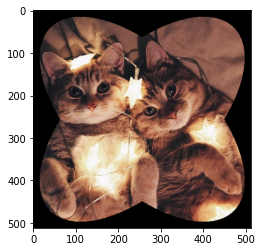

In [252]:
main()